In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

from PIL import Image
import os
import glob
import cv2
import matplotlib.pyplot as plt
import numpy as np
from capsnet import CapsNet
from data_loader import Dataset

In [17]:
class Config:
    def __init__(self, dataset='dementia'):
        if dataset == 'mnist':
            # CNN (cnn)
            self.cnn_in_channels = 1
            self.cnn_out_channels = 256
            self.cnn_kernel_size = 9

            # Primary Capsule (pc)
            self.pc_num_capsules = 8
            self.pc_in_channels = 256
            self.pc_out_channels = 32
            self.pc_kernel_size = 9
            self.pc_num_routes = 32 * 6 * 6

            # Digit Capsule (dc)
            self.dc_num_capsules = 10
            self.dc_num_routes = 32 * 6 * 6
            self.dc_in_channels = 8
            self.dc_out_channels = 16

            # Decoder
            self.input_width = 28
            self.input_height = 28

        elif dataset == 'cifar10':
            # CNN (cnn)
            self.cnn_in_channels = 3
            self.cnn_out_channels = 256
            self.cnn_kernel_size = 9

            # Primary Capsule (pc)
            self.pc_num_capsules = 8
            self.pc_in_channels = 256
            self.pc_out_channels = 32
            self.pc_kernel_size = 9
            self.pc_num_routes = 32 * 8 * 8

            # Digit Capsule (dc)
            self.dc_num_capsules = 10
            self.dc_num_routes = 32 * 8 * 8
            self.dc_in_channels = 8
            self.dc_out_channels = 16

            # Decoder
            self.input_width = 32
            self.input_height = 32

        elif dataset == 'dementia':
            # CNN (cnn)
            self.cnn_in_channels = 3
            self.cnn_out_channels = 256
            self.cnn_kernel_size = 9

            # Primary Capsule (pc)
            self.pc_num_capsules = 8
            self.pc_in_channels = 256
            self.pc_out_channels = 32
            self.pc_kernel_size = 9
            self.pc_num_routes = 32 * 24 * 24

            # Digit Capsule (dc)
            self.dc_num_capsules = 2
            self.dc_num_routes = 32 * 24 * 24
            self.dc_in_channels = 8
            self.dc_out_channels = 16

            # Decoder
            self.input_width = 64
            self.input_height = 64

In [38]:
dataset = 'dementia'
# dataset = 'mnist'
config = Config(dataset)
model = CapsNet(config)
model.load_state_dict(torch.load('./models/model.pth'))
model = model.cuda()
model.eval()

CapsNet(
  (conv_layer): ConvLayer(
    (conv): Conv2d(3, 256, kernel_size=(9, 9), stride=(1, 1))
  )
  (primary_capsules): PrimaryCaps(
    (capsules): ModuleList(
      (0): Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
      (1): Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
      (2): Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
      (3): Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
      (4): Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
      (5): Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
      (6): Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
      (7): Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
    )
  )
  (digit_capsules): DigitCaps()
  (decoder): Decoder(
    (reconstraction_layers): Sequential(
      (0): Linear(in_features=32, out_features=512, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=512, out_features=1024, bias=True)
      (3): ReLU(inplace=True)
      (4): Linear(in_features=1024, out_featur

In [39]:
transform = transforms.Compose([
                transforms.Resize((64,64)),
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,))
            ])

In [40]:
#testDir  = "/home/trojan/Desktop/dimentia/data_10slices/data_2categ/dataset_augmented/test/AD"
testDir  = "/home/trojan/Desktop/dimentia/dataset/data_2categ/data_PGGAN/test/AD"
CATEGORIES = ['AD', 'CN']
#folders_AD = ['1', '2', '3', '4', '5', '6', '7', '8']
#folders_CN = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
folders_AD = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
folders_CN = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']

In [54]:
patient = 1
AD_patient = 0
CN_patient = 0

for folder in folders_AD:
    PATH = os.path.join(testDir, folder)
    count_AD = 0
    count_CN = 0
    print('Testing for patient {}'.format(patient))
    for img in os.listdir(PATH):
        image = Image.open(os.path.join(PATH,img))
        image = image.convert('RGB')
        input = transform(image)
        input = input.view(1, 3, 64, 64)
        input = input.cuda()
        output, reconstructions, masked = model(input)
        #func = np.vectorize(np.int)
        #prediction = func(torch.max(output.data, 1)[1].cpu().numpy())
        prediction = np.argmax(masked.data.cpu().numpy(), 1)
        predicted_class = CATEGORIES[int(prediction)]
            
        print(prediction)
        print(predicted_class)
        
        if predicted_class == 'AD':
            count_AD += 1
        else:
            count_CN += 1
    
    print(f"AD votes = {count_AD}")
    print(f"CN votes = {count_CN}")
    
    if count_AD >= count_CN:
        print('Patient belongs to AD')
        AD_patient += 1
    else:
        print('Patient belongs to CN')
        CN_patient += 1
    
    patient += 1
    
accuracy = (AD_patient/len(folders_AD))*100
print(f"Accuracy is {accuracy}%")
    
    
        

Testing for patient 1
[1]
CN
[1]
CN
[1]
CN
[1]
CN
[1]
CN
[1]
CN
[1]
CN
[1]
CN
[1]
CN
[1]
CN
AD votes = 0
CN votes = 10
Patient belongs to CN
Testing for patient 2
[1]
CN
[1]
CN
[1]
CN
[1]
CN
[1]
CN
[1]
CN
[1]
CN
[1]
CN
[1]
CN
[1]
CN
AD votes = 0
CN votes = 10
Patient belongs to CN
Testing for patient 3
[1]
CN
[1]
CN
[1]
CN
[1]
CN
[1]
CN
[1]
CN
[1]
CN
AD votes = 0
CN votes = 7
Patient belongs to CN
Testing for patient 4
[1]
CN
[1]
CN
[1]
CN
[1]
CN
[1]
CN
[1]
CN
[1]
CN
[1]
CN
[1]
CN
AD votes = 0
CN votes = 9
Patient belongs to CN
Testing for patient 5
[1]
CN
[1]
CN
[1]
CN
[1]
CN
[1]
CN
[1]
CN
AD votes = 0
CN votes = 6
Patient belongs to CN
Testing for patient 6
[1]
CN
[1]
CN
[1]
CN
[1]
CN
[1]
CN
[1]
CN
[1]
CN
AD votes = 0
CN votes = 7
Patient belongs to CN
Testing for patient 7
[1]
CN
[1]
CN
[1]
CN
[1]
CN
[1]
CN
[1]
CN
[1]
CN
[1]
CN
AD votes = 0
CN votes = 8
Patient belongs to CN
Testing for patient 8
[1]
CN
[1]
CN
[1]
CN
[1]
CN
[1]
CN
[1]
CN
[1]
CN
[1]
CN
AD votes = 0
CN votes = 8
Patie

In [12]:
testDir  = "/home/trojan/Desktop/dimentia/dataset/data_2categ/data_PGGAN/test/CN"
#testDir  = "/home/trojan/Desktop/dimentia/data_10slices/data_2categ/dataset_augmented/test/CN"

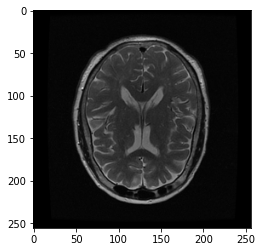

In [8]:
for folder in folders_CN:
    PATH = os.path.join(testDir, folder)
    for img in os.listdir(PATH):
        img_array = cv2.imread(os.path.join(PATH,img) ,cv2.IMREAD_COLOR)  # convert to array
        plt.imshow(img_array, cmap='gray')  # graph it
        plt.show()  # display!

        break  # we just want one for now so break
    break 

In [9]:
patient = 1
AD_patient = 0
CN_patient = 0

for folder in folders_CN:
    PATH = os.path.join(testDir, folder)
    count_AD = 0
    count_CN = 0
    print('Testing for patient {}'.format(patient))
    for img in os.listdir(PATH):
        #prediction = model.predict_classes([prepare(os.path.join(PATH,img))])
        prediction = (model.predict([prepare(os.path.join(PATH,img))])>0.5).astype("int32")
        #predicted_class_indice=np.argmax(prediction,axis=-1)
        predicted_class = CATEGORIES[int(prediction)]
        #print(predicted_class_indice)
        #print(prediction)
        #print(predicted_class)
        if predicted_class == 'AD':
            count_AD += 1
        else:
            count_CN += 1
    
    print(f"AD votes = {count_AD}")
    print(f"CN votes = {count_CN}")
    
    if count_AD > count_CN:
        print('Patient belongs to AD')
        AD_patient += 1
    else:
        print('Patient belongs to CN')
        CN_patient += 1
    
    patient += 1
    
accuracy = (CN_patient/len(folders_CN))*100
print(f"Accuracy is {accuracy}%")
    
    
        

Testing for patient 1
AD votes = 0
CN votes = 8
Patient belongs to CN
Testing for patient 2
AD votes = 2
CN votes = 7
Patient belongs to CN
Testing for patient 3
AD votes = 0
CN votes = 8
Patient belongs to CN
Testing for patient 4
AD votes = 1
CN votes = 5
Patient belongs to CN
Testing for patient 5
AD votes = 0
CN votes = 8
Patient belongs to CN
Testing for patient 6
AD votes = 4
CN votes = 4
Patient belongs to CN
Testing for patient 7
AD votes = 6
CN votes = 2
Patient belongs to AD
Testing for patient 8
AD votes = 1
CN votes = 8
Patient belongs to CN
Testing for patient 9
AD votes = 0
CN votes = 9
Patient belongs to CN
Testing for patient 10
AD votes = 8
CN votes = 2
Patient belongs to AD
Accuracy is 80.0%
